# Statistical Analysis: Descriptive Statistics, Distributions, and Statistical Tests

This notebook covers:
- **Section 1**: Descriptive Statistics (mean, median, std, range)
- **Section 2**: Distribution Analysis (histograms, box plots)
- **Section 3**: Time Series Trends
- **Section 4**: Correlation Analysis
- **Section 5**: Statistical Tests (t-tests, chi-square, correlation significance)
- **Focus**: Pure statistical analysis to understand and validate the dataset

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency, pearsonr
import os
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Create figures directory for paper
os.makedirs('figures', exist_ok=True)
print("Figures directory created/verified. All figures will be saved to 'figures/' folder.")

Figures directory created/verified. All figures will be saved to 'figures/' folder.


## Load Cleaned Data

In [5]:
# Load cleaned data
df = pd.read_csv('data/cleaned_data.csv')

# Ensure Date is datetime
if not pd.api.types.is_datetime64_any_dtype(df['Date']):
    df['Date'] = pd.to_datetime(df['Date'])

# Ensure Is_Weekend column exists
if 'Is_Weekend' not in df.columns:
    df['Is_Weekend'] = df['Date'].dt.dayofweek.isin([5, 6])  # Saturday=5, Sunday=6

print(f"Loaded {len(df)} samples")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\\nDataset shape: {df.shape}")
print(f"\\nColumns: {list(df.columns)}")

Loaded 89 samples
Date range: 2025-11-19 00:00:00 to 2026-02-15 00:00:00
\nDataset shape: (89, 31)
\nColumns: ['Date', 'Day of the Week', 'Sleep_Hours', 'Work_Hours', 'Study_Hours', 'Chore_Time_Mins', 'Distraction_Time_Mins', 'Travel Time (Hours)', 'Mode of Transport', 'Music_Time_Hours', 'Main_Music_Genre', 'Tasks_Completed', 'Mood_Rating', 'Focus_Rating', 'Notes', 'Computed_Day', 'Day_Match', 'Is_Weekend', 'Transport_Motorcycle', 'Transport_Public_Transport', 'Genre_Pop', 'Genre_Jazz', 'Genre_OPM', 'Genre_News', 'Genre_Classical', 'Genre_Podcast', 'Genre_EDM', 'Genre_Lofi', 'Genre_Oldies', 'Genre_RandB', 'Genre_Rock']


## Section 1: Descriptive Statistics

In [6]:
# Calculate descriptive statistics for all numerical variables
numerical_vars = ['Sleep_Hours', 'Work_Hours', 'Study_Hours', 'Travel Time (Hours)', 
                  'Distraction_Time_Mins', 'Tasks_Completed', 'Mood_Rating', 'Focus_Rating']

desc_stats = df[numerical_vars].describe()
desc_stats.loc['range'] = desc_stats.loc['max'] - desc_stats.loc['min']

print("Descriptive Statistics for Numerical Variables")
print("="*80)
print(desc_stats.round(2))

# Save to CSV for paper
desc_stats.to_csv('data/descriptive_statistics.csv')
print("\nDescriptive statistics saved to data/descriptive_statistics.csv")

Descriptive Statistics for Numerical Variables
       Sleep_Hours  Work_Hours  Study_Hours  Travel Time (Hours)  \
count        89.00       89.00        89.00                89.00   
mean          6.92        4.94         4.68                 1.70   
std           1.80        3.34         2.38                 0.73   
min           2.00        0.00         0.00                 1.00   
25%           6.00        1.00         3.00                 1.10   
50%           7.00        7.00         4.70                 1.40   
75%           8.00        8.00         6.00                 2.50   
max          12.00       10.00        11.73                 3.00   
range        10.00       10.00        11.73                 2.00   

       Distraction_Time_Mins  Tasks_Completed  Mood_Rating  Focus_Rating  
count                  89.00            89.00        89.00         89.00  
mean                  253.36             3.82         3.40          3.28  
std                    85.14             1.87  

## Section 2: Distribution Analysis - Box Plots

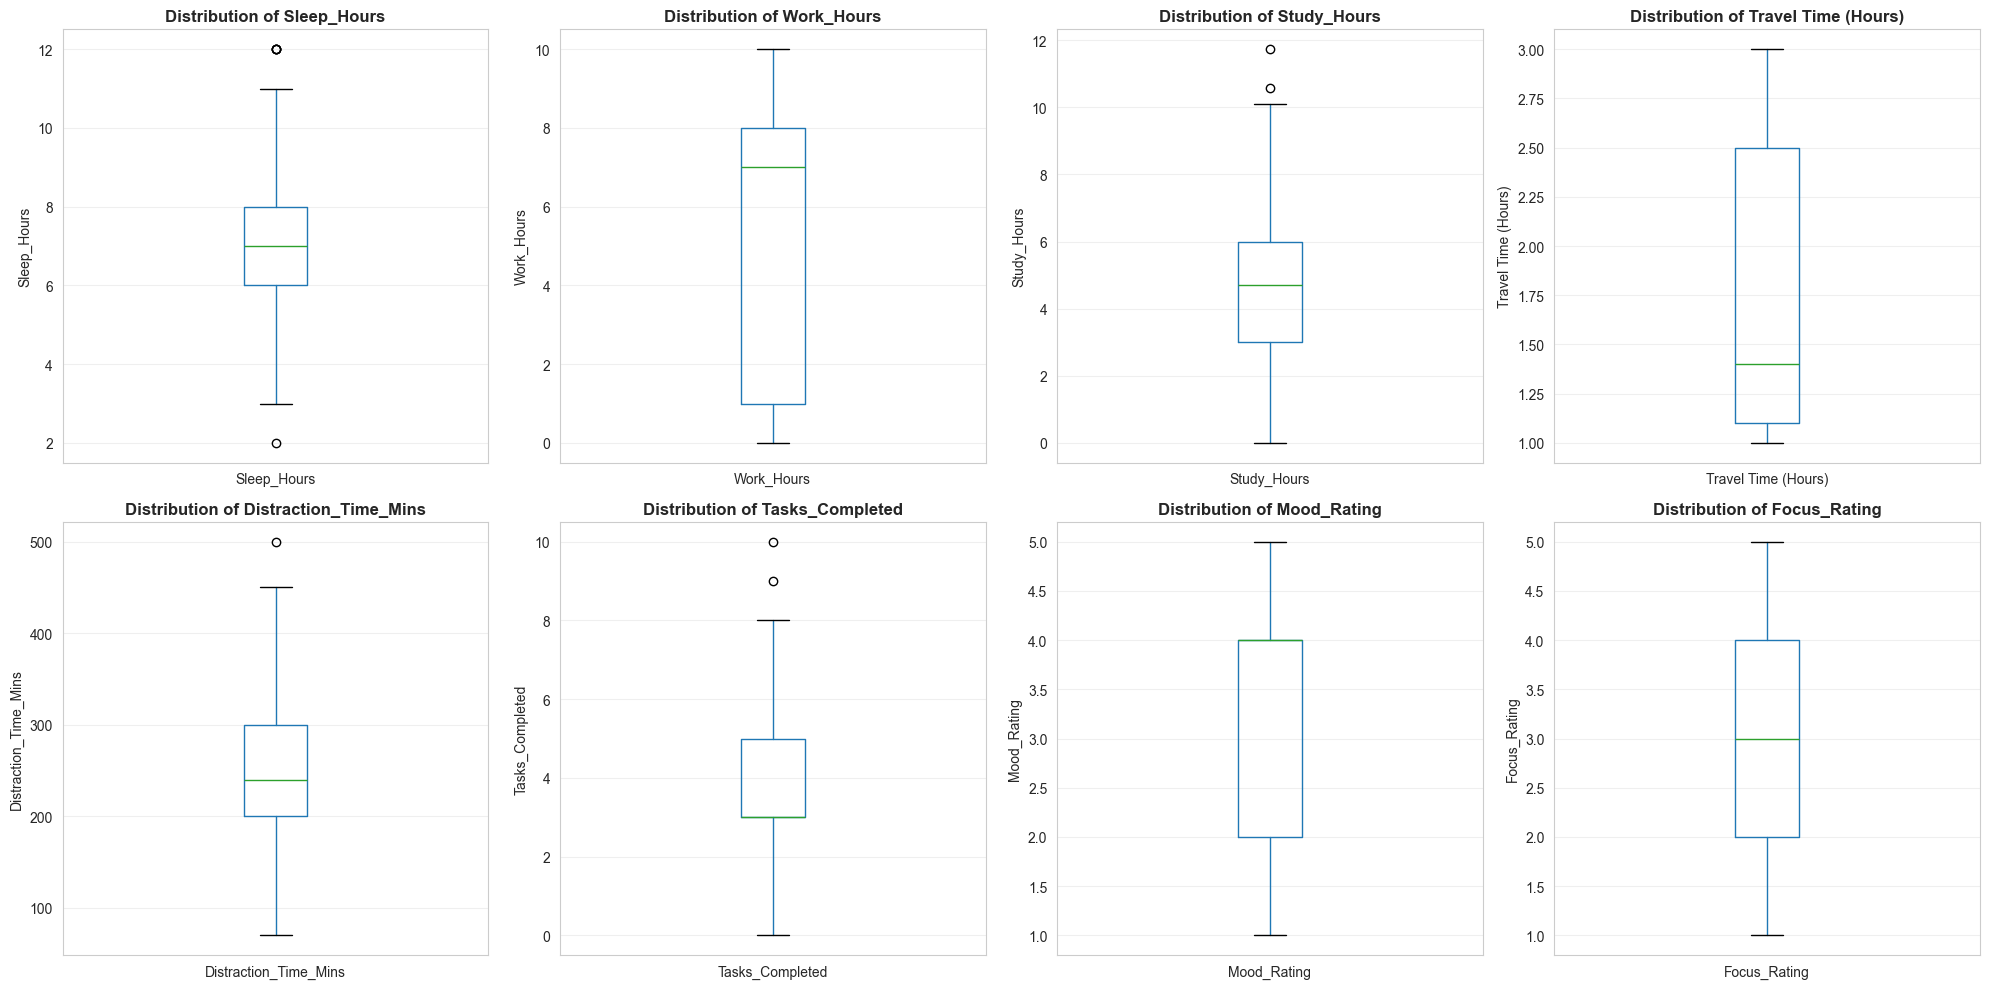

Box plots created and saved to figures/Figure_4_Box_Plots_Distributions.png


In [7]:
# Create box plots for key variables to show distributions and outliers
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, var in enumerate(numerical_vars):
    ax = axes[idx]
    df.boxplot(column=var, ax=ax, grid=False)
    ax.set_title(f'Distribution of {var}', fontsize=12, fontweight='bold')
    ax.set_ylabel(var, fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/Figure_4_Box_Plots_Distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Box plots created and saved to figures/Figure_4_Box_Plots_Distributions.png")

## Section 3: Time Series Analysis

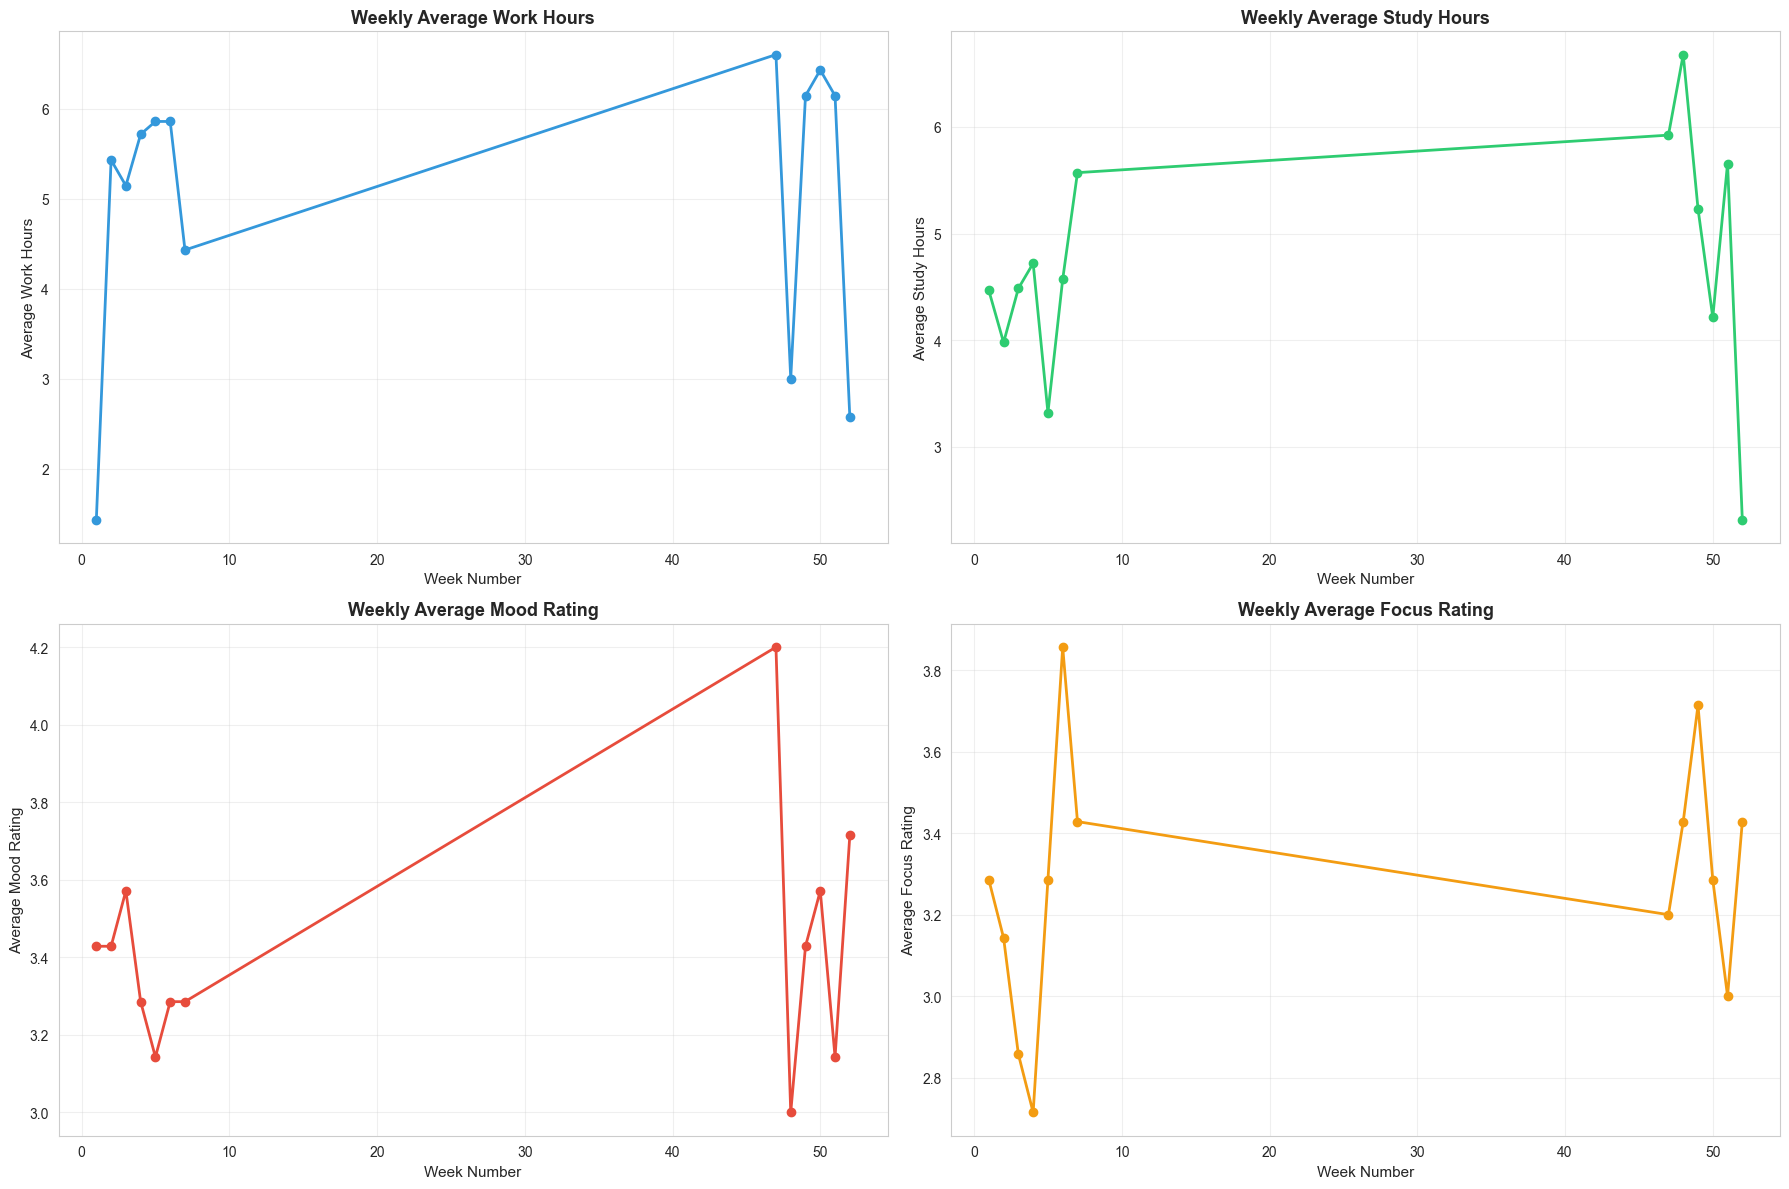

Weekly trend analysis completed and saved to figures/Figure_5_Weekly_Trends.png


In [8]:
# Analyze time series trends for key variables
df_sorted = df.sort_values('Date').copy()

# Calculate weekly averages
df_sorted['Week'] = df_sorted['Date'].dt.isocalendar().week
weekly_avg = df_sorted.groupby('Week')[['Work_Hours', 'Study_Hours', 'Mood_Rating', 'Focus_Rating']].mean()

# Create time series plot with weekly averages
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Work_Hours weekly average
axes[0, 0].plot(weekly_avg.index, weekly_avg['Work_Hours'], marker='o', linewidth=2, color='#3498db')
axes[0, 0].set_title('Weekly Average Work Hours', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Week Number', fontsize=11)
axes[0, 0].set_ylabel('Average Work Hours', fontsize=11)
axes[0, 0].grid(alpha=0.3)

# Plot 2: Study_Hours weekly average
axes[0, 1].plot(weekly_avg.index, weekly_avg['Study_Hours'], marker='o', linewidth=2, color='#2ecc71')
axes[0, 1].set_title('Weekly Average Study Hours', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Week Number', fontsize=11)
axes[0, 1].set_ylabel('Average Study Hours', fontsize=11)
axes[0, 1].grid(alpha=0.3)

# Plot 3: Mood_Rating weekly average
axes[1, 0].plot(weekly_avg.index, weekly_avg['Mood_Rating'], marker='o', linewidth=2, color='#e74c3c')
axes[1, 0].set_title('Weekly Average Mood Rating', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Week Number', fontsize=11)
axes[1, 0].set_ylabel('Average Mood Rating', fontsize=11)
axes[1, 0].grid(alpha=0.3)

# Plot 4: Focus_Rating weekly average
axes[1, 1].plot(weekly_avg.index, weekly_avg['Focus_Rating'], marker='o', linewidth=2, color='#f39c12')
axes[1, 1].set_title('Weekly Average Focus Rating', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Week Number', fontsize=11)
axes[1, 1].set_ylabel('Average Focus Rating', fontsize=11)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/Figure_5_Weekly_Trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("Weekly trend analysis completed and saved to figures/Figure_5_Weekly_Trends.png")

## Section 4: Correlation Analysis

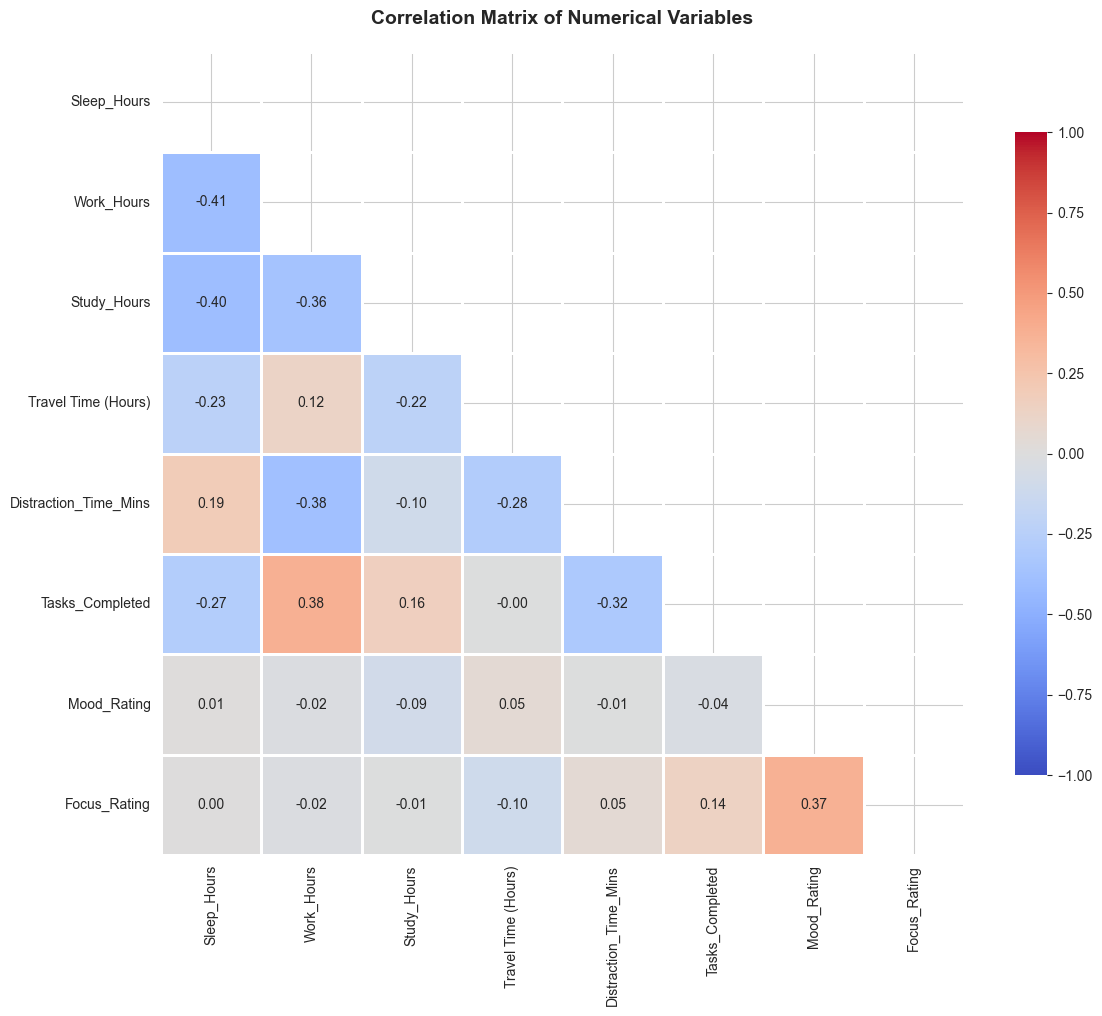


Significant Correlations (p < 0.05):
Sleep_Hours ↔ Work_Hours: r = -0.406, p = 0.0001
Sleep_Hours ↔ Study_Hours: r = -0.404, p = 0.0001
Sleep_Hours ↔ Travel Time (Hours): r = -0.233, p = 0.0280
Sleep_Hours ↔ Tasks_Completed: r = -0.275, p = 0.0092
Work_Hours ↔ Study_Hours: r = -0.364, p = 0.0005
Work_Hours ↔ Distraction_Time_Mins: r = -0.384, p = 0.0002
Work_Hours ↔ Tasks_Completed: r = 0.378, p = 0.0003
Study_Hours ↔ Travel Time (Hours): r = -0.220, p = 0.0380
Travel Time (Hours) ↔ Distraction_Time_Mins: r = -0.285, p = 0.0068
Distraction_Time_Mins ↔ Tasks_Completed: r = -0.319, p = 0.0023
Mood_Rating ↔ Focus_Rating: r = 0.374, p = 0.0003

Correlation matrix saved to figures/Figure_6_Correlation_Matrix_Statistical.png
Total significant correlations: 11


In [9]:
# Calculate correlation matrix and identify significant correlations
correlation_vars = ['Sleep_Hours', 'Work_Hours', 'Study_Hours', 'Travel Time (Hours)', 
                    'Distraction_Time_Mins', 'Tasks_Completed', 'Mood_Rating', 'Focus_Rating']

corr_matrix = df[correlation_vars].corr(method='pearson')

# Create correlation heatmap
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, 
            mask=mask, ax=ax, vmin=-1, vmax=1)
ax.set_title('Correlation Matrix of Numerical Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('figures/Figure_6_Correlation_Matrix_Statistical.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify significant correlations (p < 0.05)
print("\nSignificant Correlations (p < 0.05):")
print("="*60)
significant_corrs = []
for i in range(len(correlation_vars)):
    for j in range(i+1, len(correlation_vars)):
        var1 = correlation_vars[i]
        var2 = correlation_vars[j]
        corr_coef, p_value = pearsonr(df[var1].dropna(), df[var2].dropna())
        if p_value < 0.05:
            significant_corrs.append({
                'Variable 1': var1,
                'Variable 2': var2,
                'Correlation': corr_coef,
                'P-value': p_value
            })
            print(f"{var1} ↔ {var2}: r = {corr_coef:.3f}, p = {p_value:.4f}")

if len(significant_corrs) == 0:
    print("No significant correlations found (p < 0.05)")

print(f"\nCorrelation matrix saved to figures/Figure_6_Correlation_Matrix_Statistical.png")
print(f"Total significant correlations: {len(significant_corrs)}")



In [10]:
# Additional Statistical Tests: Group Comparisons

# 1. T-test: Work_Hours by Weekend status
weekend_work = df[df['Is_Weekend']]['Work_Hours'].dropna()
weekday_work = df[~df['Is_Weekend']]['Work_Hours'].dropna()

if len(weekend_work) > 0 and len(weekday_work) > 0:
    t_stat_work, p_value_work = ttest_ind(weekend_work, weekday_work)
    print("Independent Samples t-test: Work_Hours (Weekend vs Weekday)")
    print("="*60)
    print(f"Weekend Work: {weekend_work.mean():.2f} ± {weekend_work.std():.2f} (n={len(weekend_work)})")
    print(f"Weekday Work: {weekday_work.mean():.2f} ± {weekday_work.std():.2f} (n={len(weekday_work)})")
    print(f"t-statistic: {t_stat_work:.3f}")
    print(f"p-value: {p_value_work:.4f}")
    print(f"Significant: {'Yes' if p_value_work < 0.05 else 'No'} (α=0.05)")
    print()

Independent Samples t-test: Work_Hours (Weekend vs Weekday)
Weekend Work: 2.38 ± 2.74 (n=26)
Weekday Work: 6.00 ± 2.99 (n=63)
t-statistic: -5.310
p-value: 0.0000
Significant: Yes (α=0.05)



In [11]:
# 2. T-test: Study_Hours by Weekend status
weekend_study = df[df['Is_Weekend']]['Study_Hours'].dropna()
weekday_study = df[~df['Is_Weekend']]['Study_Hours'].dropna()

if len(weekend_study) > 0 and len(weekday_study) > 0:
    t_stat_study, p_value_study = ttest_ind(weekend_study, weekday_study)
    print("Independent Samples t-test: Study_Hours (Weekend vs Weekday)")
    print("="*60)
    print(f"Weekend Study: {weekend_study.mean():.2f} ± {weekend_study.std():.2f} (n={len(weekend_study)})")
    print(f"Weekday Study: {weekday_study.mean():.2f} ± {weekday_study.std():.2f} (n={len(weekday_study)})")
    print(f"t-statistic: {t_stat_study:.3f}")
    print(f"p-value: {p_value_study:.4f}")
    print(f"Significant: {'Yes' if p_value_study < 0.05 else 'No'} (α=0.05)")
    print()

Independent Samples t-test: Study_Hours (Weekend vs Weekday)
Weekend Study: 5.94 ± 2.68 (n=26)
Weekday Study: 4.15 ± 2.05 (n=63)
t-statistic: 3.400
p-value: 0.0010
Significant: Yes (α=0.05)



## Phase 3.5: Comparative Clustering Analysis

In [12]:
# Statistical Tests: t-tests and chi-square tests

# 1. Independent samples t-test: Mood_Rating by Weekend status
weekend_mood = df[df['Is_Weekend']]['Mood_Rating'].dropna()
weekday_mood = df[~df['Is_Weekend']]['Mood_Rating'].dropna()

if len(weekend_mood) > 0 and len(weekday_mood) > 0:
    t_stat_mood, p_value_mood = ttest_ind(weekend_mood, weekday_mood)
    print("Independent Samples t-test: Mood_Rating (Weekend vs Weekday)")
    print("="*60)
    print(f"Weekend Mood: {weekend_mood.mean():.2f} ± {weekend_mood.std():.2f} (n={len(weekend_mood)})")
    print(f"Weekday Mood: {weekday_mood.mean():.2f} ± {weekday_mood.std():.2f} (n={len(weekday_mood)})")
    print(f"t-statistic: {t_stat_mood:.3f}")
    print(f"p-value: {p_value_mood:.4f}")
    print(f"Significant: {'Yes' if p_value_mood < 0.05 else 'No'} (α=0.05)")
    print()

Independent Samples t-test: Mood_Rating (Weekend vs Weekday)
Weekend Mood: 3.38 ± 1.06 (n=26)
Weekday Mood: 3.41 ± 1.09 (n=63)
t-statistic: -0.112
p-value: 0.9114
Significant: No (α=0.05)



In [13]:
# 3. T-test: Sleep_Hours by Weekend status
weekend_sleep = df[df['Is_Weekend']]['Sleep_Hours'].dropna()
weekday_sleep = df[~df['Is_Weekend']]['Sleep_Hours'].dropna()

if len(weekend_sleep) > 0 and len(weekday_sleep) > 0:
    t_stat_sleep, p_value_sleep = ttest_ind(weekend_sleep, weekday_sleep)
    print("Independent Samples t-test: Sleep_Hours (Weekend vs Weekday)")
    print("="*60)
    print(f"Weekend Sleep: {weekend_sleep.mean():.2f} ± {weekend_sleep.std():.2f} (n={len(weekend_sleep)})")
    print(f"Weekday Sleep: {weekday_sleep.mean():.2f} ± {weekday_sleep.std():.2f} (n={len(weekday_sleep)})")
    print(f"t-statistic: {t_stat_sleep:.3f}")
    print(f"p-value: {p_value_sleep:.4f}")
    print(f"Significant: {'Yes' if p_value_sleep < 0.05 else 'No'} (α=0.05)")

Independent Samples t-test: Sleep_Hours (Weekend vs Weekday)
Weekend Sleep: 7.50 ± 2.14 (n=26)
Weekday Sleep: 6.67 ± 1.59 (n=63)
t-statistic: 2.006
p-value: 0.0480
Significant: Yes (α=0.05)


## Section 5 (continued): Additional Statistical Tests

### Statistical Test 1: Focus_Rating by Weekend Status

In [14]:
# Independent samples t-test: Focus_Rating by Weekend status
weekend_focus = df[df['Is_Weekend']]['Focus_Rating'].dropna()
weekday_focus = df[~df['Is_Weekend']]['Focus_Rating'].dropna()

if len(weekend_focus) > 0 and len(weekday_focus) > 0:
    t_stat_focus, p_value_focus = ttest_ind(weekend_focus, weekday_focus)
    print("Independent Samples t-test: Focus_Rating (Weekend vs Weekday)")
    print("="*60)
    print(f"Weekend Focus: {weekend_focus.mean():.2f} ± {weekend_focus.std():.2f} (n={len(weekend_focus)})")
    print(f"Weekday Focus: {weekday_focus.mean():.2f} ± {weekday_focus.std():.2f} (n={len(weekday_focus)})")
    print(f"t-statistic: {t_stat_focus:.3f}")
    print(f"p-value: {p_value_focus:.4f}")
    print(f"Significant: {'Yes' if p_value_focus < 0.05 else 'No'} (α=0.05)")

Independent Samples t-test: Focus_Rating (Weekend vs Weekday)
Weekend Focus: 3.04 ± 1.25 (n=26)
Weekday Focus: 3.38 ± 1.24 (n=63)
t-statistic: -1.185
p-value: 0.2394
Significant: No (α=0.05)


### Statistical Test 2: Correlation Significance Tests

Correlation Significance Tests:
Work_Hours ↔ Mood_Rating: r = -0.016, p = 0.8834 
Study_Hours ↔ Mood_Rating: r = -0.087, p = 0.4177 
Distraction_Time_Mins ↔ Focus_Rating: r = 0.049, p = 0.6479 
Sleep_Hours ↔ Mood_Rating: r = 0.012, p = 0.9112 
Work_Hours ↔ Focus_Rating: r = -0.021, p = 0.8467 


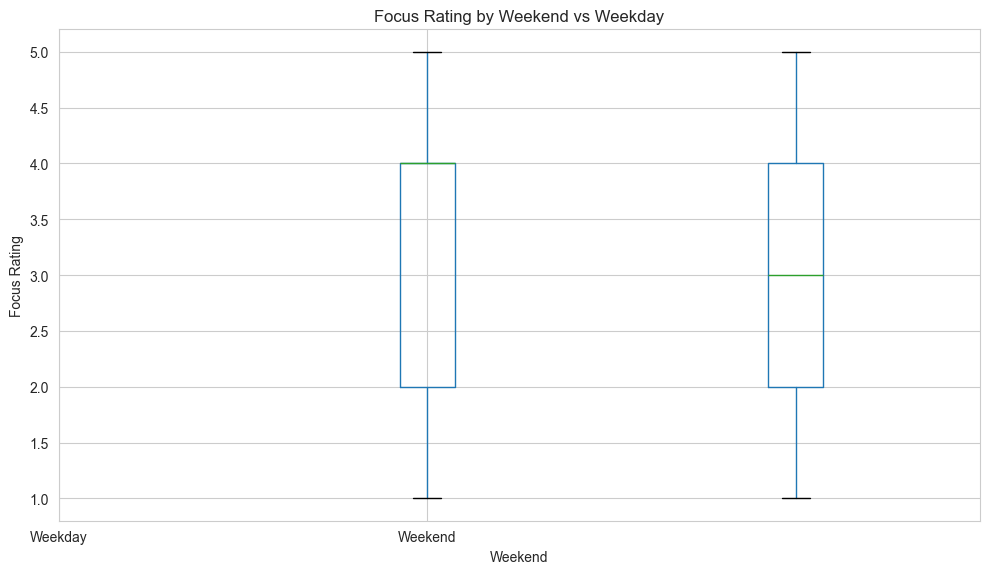

In [15]:
# Test correlation significance for key variable pairs
print("Correlation Significance Tests:")
print("="*60)

key_pairs = [
    ('Work_Hours', 'Mood_Rating'),
    ('Study_Hours', 'Mood_Rating'),
    ('Distraction_Time_Mins', 'Focus_Rating'),
    ('Sleep_Hours', 'Mood_Rating'),
    ('Work_Hours', 'Focus_Rating')
]

for var1, var2 in key_pairs:
    if var1 in df.columns and var2 in df.columns:
        data1 = df[var1].dropna()
        data2 = df[var2].dropna()
        # Align indices
        common_idx = data1.index.intersection(data2.index)
        if len(common_idx) > 2:
            corr_coef, p_value = pearsonr(data1.loc[common_idx], data2.loc[common_idx])
            sig = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
            print(f"{var1} ↔ {var2}: r = {corr_coef:.3f}, p = {p_value:.4f} {sig}")

# Box plot: Focus Rating by Weekend status (K-Means not in notebook)
plt.figure(figsize=(10, 6))
df.boxplot(column='Focus_Rating', by='Is_Weekend', ax=plt.gca())
plt.title('Focus Rating by Weekend vs Weekday')
plt.suptitle('')
plt.xlabel('Weekend')
plt.ylabel('Focus Rating')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.tight_layout()
plt.show()

### Statistical Test 3: Chi-square Tests for Categorical Relationships

In [16]:
# Chi-square test: Weekend × High Volume
if 'High_Volume' not in df.columns:
    work_threshold = df['Work_Hours'].median()
    df['High_Volume'] = df['Work_Hours'] >= work_threshold

if 'Is_Weekend' in df.columns and 'High_Volume' in df.columns:
    contingency = pd.crosstab(df['Is_Weekend'], df['High_Volume'])
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    
    print("Chi-square Test: Weekend × High Volume")
    print("="*60)
    print("Contingency Table:")
    print(contingency)
    print(f"\nChi-square statistic: {chi2:.3f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"Significant: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")

Chi-square Test: Weekend × High Volume
Contingency Table:
High_Volume  False  True 
Is_Weekend               
False           22     41
True            22      4

Chi-square statistic: 16.249
p-value: 0.0001
Degrees of freedom: 1
Significant: Yes (α=0.05)


### Summary of Statistical Tests

In [17]:
# Summary of all statistical tests performed
print("\n" + "="*60)
print("SUMMARY OF STATISTICAL TESTS")
print("="*60)
print("\n1. Descriptive Statistics: Mean, median, std, range for all variables")
print("2. Distribution Analysis: Histograms and box plots")
print("3. Time Series Analysis: Weekly trends")
print("4. Correlation Analysis: Pearson correlations with significance tests")
print("5. T-tests: Weekend vs Weekday comparisons (Mood, Focus)")
print("6. Chi-square Tests: Categorical relationships")
print("\nAll tests use α = 0.05 significance level")
print("="*60)


SUMMARY OF STATISTICAL TESTS

1. Descriptive Statistics: Mean, median, std, range for all variables
2. Distribution Analysis: Histograms and box plots
3. Time Series Analysis: Weekly trends
4. Correlation Analysis: Pearson correlations with significance tests
5. T-tests: Weekend vs Weekday comparisons (Mood, Focus)
6. Chi-square Tests: Categorical relationships

All tests use α = 0.05 significance level


## Save Results

In [19]:
# Save statistical analysis results
# Descriptive statistics already saved earlier
print("\nStatistical analysis complete!")
print("All results have been saved and figures generated.")
print("\nKey outputs:")
print("- Descriptive statistics: data/descriptive_statistics.csv")
print("- Figure_4_Box_Plots_Distributions.png")
print("- Figure_5_Weekly_Trends.png")
print("- Figure_6_Correlation_Matrix_Statistical.png")
print("(Figures saved to figures/ directory)")


Statistical analysis complete!
All results have been saved and figures generated.

Key outputs:
- Descriptive statistics: data/descriptive_statistics.csv
- Figure_4_Box_Plots_Distributions.png
- Figure_5_Weekly_Trends.png
- Figure_6_Correlation_Matrix_Statistical.png
(Figures saved to figures/ directory)
